# RFM Customer Segmentation

**RFM** is a customer segmentation algorithm which segments the customers based on only three points

* **Recency**: How recently did the customer purchased something?
* **Frequency**: How frequently does the customer purchase something?
* **Monetary**: How nuch has the customer spent?

This helps businesses to properly segment their customers into various groups and launch different programs and campaigns on the basis of the segmentation

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [59]:
df = pd.read_csv("/kaggle/input/online-retail-ii-uci/online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


* **Invoice**: Invoice Number 
* **StockCode**: Product Code
* **Description**: Product Name
* **Quantity**: Quantities of each product per transaction
* **InvoiceDate**: Date and Time of Invoice
* **Price**: Unit Price
* **Customer ID**: Customer Number
* **Country**: Country name

## 1) Data Preprocessing
* Duplicate Records
* Missing Values
* Inconsistent Format

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


*  Removing Duplicates

In [61]:
print("Number Of DUplicate Entries: ",df.duplicated().sum())
df.drop_duplicates(inplace = True)
print("DUPLICATES REMOVED")

Number Of DUplicate Entries:  34335
DUPLICATES REMOVED


* Consistent Formatting

In [62]:
df['Customer ID'] = df['Customer ID'].astype(str)

In [63]:
df.describe()

,Quantity,Price
count,1.033036e+06,1.033036e+06
mean,1.007688e+01,4.613980e+00
std,1.751976e+02,1.223975e+02
min,-8.099500e+04,-5.359436e+04
25%,1.000000e+00,1.250000e+00
50%,3.000000e+00,2.100000e+00
75%,1.000000e+01,4.150000e+00
max,8.099500e+04,3.897000e+04


Lets check the total number of products, transactions and customers

In [64]:
print("Total Number of Transactions: ",len(df['Invoice'].value_counts()))
print("Total Number of Products: ",len(df['StockCode'].value_counts()))
print("Total Number of Customers: ",len(df['Customer ID'].value_counts()))

Total Number of Transactions:  53628
Total Number of Products:  5305
Total Number of Customers:  5943


* Missing Values
  

In [65]:
cancel = df['Invoice'].astype(str).str.contains('c')
cancel.fillna(0,inplace=True)
cancel = cancel.astype(int)
cancel.value_counts()

Invoice
0    1033036
Name: count, dtype: int64

In [66]:
df = df[df['Customer ID'].notna()]

In [67]:
print("Total number of transaction with negative quantity:", df[df['Quantity'] <= 0 ]['Quantity'].count())
print("Total number of transaction with negative Price:", df[df['Price'] <= 0 ]['Price'].count())

Total number of transaction with negative quantity: 22496
Total number of transaction with negative Price: 6019


These transactions are clearly wrong so we filter out these transactions

In [68]:
df = df[(df['Price']>0) & (df['Quantity']>0)]

## 2) Create RFM Table

In [69]:
print("Start Date: ",df['InvoiceDate'].min())
print("End Date: ",df['InvoiceDate'].max())

Start Date:  2009-12-01 07:45:00
End Date:  2011-12-09 12:50:00


In [70]:
from datetime import datetime
df['Revenue'] = df['Price'] * df['Quantity']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [71]:
import datetime as dt
our_date = max(df.InvoiceDate) + dt.timedelta(days=1)
print(our_date)

2011-12-10


In [72]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda x: (our_date - x.max()).days, 'Invoice': lambda x: len(x), 'Revenue': lambda x: x.sum()}).reset_index()
rfm['InvoiceDate'] = rfm['InvoiceDate'].astype(int)
rfm.rename(columns = {'InvoiceDate' : 'Recency'
                      , 'Invoice' : 'Frequency', 
                         'Revenue' : 'Monetary Value'},inplace = True)
rfm.head()

,Customer ID,Recency,Frequency,Monetary Value
0,12346.0,326,34,77556.46
1,12347.0,3,222,4921.53
2,12348.0,76,51,2019.40
3,12349.0,19,175,4428.69
4,12350.0,311,17,334.40


## 3) RFM Metric and RFM Segments

In [73]:
rfm['R'] = pd.qcut(rfm['Recency'],5,labels=[5,4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'],5,labels=[5,4,3,2,1]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary Value'],5,labels=[5,4,3,2,1]).astype(int)
rfm.head()

,Customer ID,Recency,Frequency,Monetary Value,R,F,M
0,12346.0,326,34,77556.46,2,4,1
1,12347.0,3,222,4921.53,5,1,1
2,12348.0,76,51,2019.40,3,3,2
3,12349.0,19,175,4428.69,5,1,1
4,12350.0,311,17,334.40,2,4,4


In [74]:
rfm['RFM_segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()

,Customer ID,Recency,Frequency,Monetary Value,R,F,M,RFM_segment,RFM_score
0,12346.0,326,34,77556.46,2,4,1,241,7
1,12347.0,3,222,4921.53,5,1,1,511,7
2,12348.0,76,51,2019.40,3,3,2,332,8
3,12349.0,19,175,4428.69,5,1,1,511,7
4,12350.0,311,17,334.40,2,4,4,244,10


In [75]:
def segment(score):
    if score>=10:
        return 'Top Customers'
    elif score>=7:
        return 'Loyal Customers'
    elif score>=5:
        return 'Potential'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_score'].apply(segment)
rfm.head()

,Customer ID,Recency,Frequency,Monetary Value,R,F,M,RFM_segment,RFM_score,Segment
0,12346.0,326,34,77556.46,2,4,1,241,7,Loyal Customers
1,12347.0,3,222,4921.53,5,1,1,511,7,Loyal Customers
2,12348.0,76,51,2019.40,3,3,2,332,8,Loyal Customers
3,12349.0,19,175,4428.69,5,1,1,511,7,Loyal Customers
4,12350.0,311,17,334.40,2,4,4,244,10,Top Customers


Let us count the customers in each segment

In [76]:
print("Total Number of Top Customers: ",rfm[rfm['RFM_score']>=10].shape[0])
print("Total Number of Loyal Customers: ",rfm[rfm['RFM_score']>=7].shape[0])
print("Total Number of Potential Customers: ",rfm[rfm['RFM_score']>=5].shape[0])
print("Total Number of Lost Customers: ",rfm[rfm['RFM_score']<5].shape[0])

Total Number of Top Customers:  2466
Total Number of Loyal Customers:  5073
Total Number of Potential Customers:  5808
Total Number of Lost Customers:  71


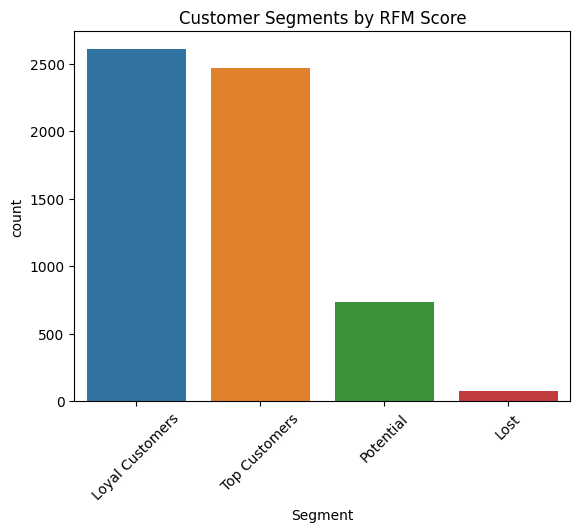

In [77]:
sns.countplot(data=rfm, x='Segment')
plt.xticks(rotation=45)
plt.title("Customer Segments by RFM Score")
plt.show()

## 4) KMeans Clustering

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
rfm_clustering =rfm[['Recency','Frequency','Monetary Value']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_clustering)

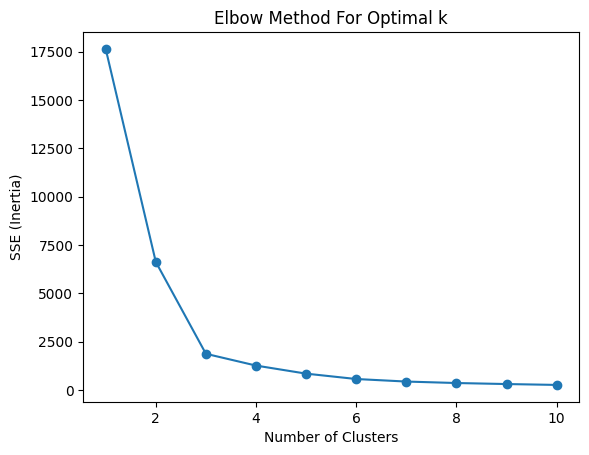

In [79]:
sse = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,random_state = 30)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method For Optimal k')
plt.show()

It seems that the perfect number of clusters is **3** according to the elbow method

In [80]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

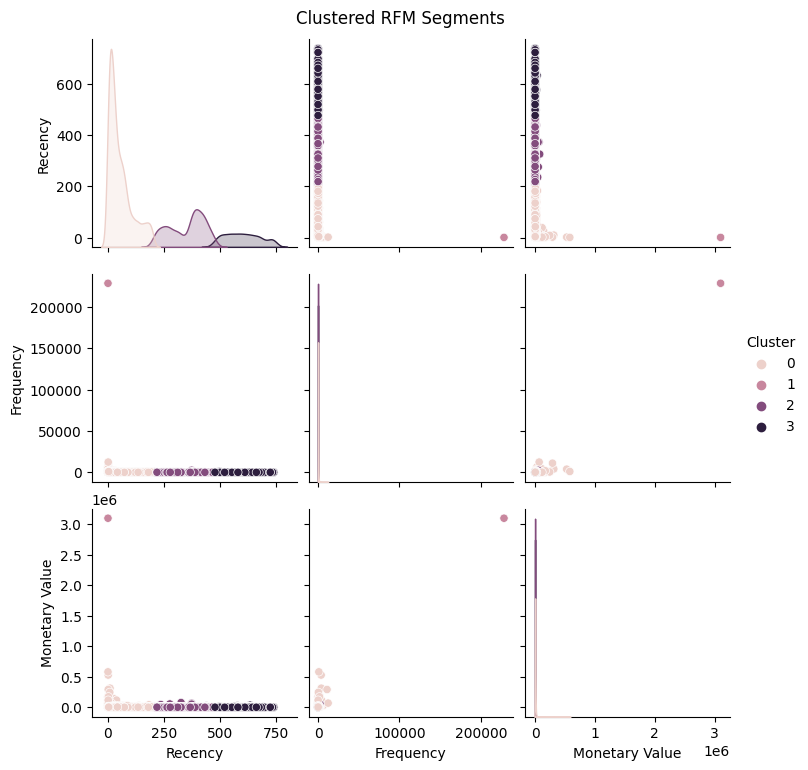

In [81]:
import seaborn as sns

sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary Value'])
plt.suptitle("Clustered RFM Segments", y=1.02)
plt.show()


# Conclusion

We have a significant number of Loyal Customers who could be converted into Top Customers by promoting high-value or exclusive products. For Lost Customers, strong return offers or win-back campaigns with deep discounts might help re-engage them. Potential Customers show promise and can be nurtured with consistent marketing and moderate promotional offers to increase their engagement.